### Codio Activity 12.6: Evaluation Curves: Precision vs. Recall and ROC

**Estimated Time: 90 Minutes**

**Total Points: 60**

This assignment focuses on using the precision recall curves and receiver operating characteristic (roc) curves to examine tradeoffs in classifier performance.  Also, these curves and the area determined by them can be viewed as a metric itself.  Scikitlearn implements all of this, and by the end of this activity you should be comfortable with these functions.

#### Index

- [Problem 1](#Problem-1)
- [Problem 2](#Problem-2)
- [Problem 3](#Problem-3)
- [Problem 4](#Problem-4)
- [Problem 5](#Problem-5)
- [Problem 6](#Problem-6)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve
from sklearn.datasets import load_breast_cancer
from sklearn.compose import make_column_transformer
from sklearn import set_config

set_config(display="diagram")

### The Data


For this exercise, you will again use the credit card default data.  It is loaded and split below.  A pipeline for model building is also instantiated and fit. 

In [25]:
default = pd.read_csv('data/default.csv', index_col=0)

In [26]:
default.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [47]:
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['student']), remainder = StandardScaler())
X_train, X_test, y_train, y_test = train_test_split(default.drop('default', axis = 1), default.default, random_state=42, stratify = default.default)
knn_pipe = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier(n_neighbors = 10))])

In [48]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['student'])])),
                ('knn', KNeighborsClassifier(n_neighbors=10))])

In [57]:
test_predictions = knn_pipe.predict_proba(X_test)
test_predictions

array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

[Back to top](#-Index)

### Problem 1

#### Precision for different thresholds

**10 Points**

Below, complete the function `precision_thresh` to take in a numpy array of predicted probabilities, and return a prediction for the positive class at or above that threshold, and negative for that below.  

In [58]:
### GRADED
def precision_thresh(predict_probs, y_test, thresh):
    """Given predicted probabilities and a threshold, this function
    computes predictions for the positive class at or above the threshold
    and returns the subesequent precision score for that thresholds predictions 
    against the test data.
    
    Parameters
    ----------
    predict_probs: type 'np.ndarray'
        1D NumPy array of probabilities for positive class
    y_test: type `np.ndarray`
        1D NumPy array of test label
    thresh: type `float`
        threshold for positive classification at or above
          
    Returns a float for precision value
    """
    return None

### BEGIN SOLUTION
def precision_thresh(predict_probs, y_test, thresh):
    preds = np.where(predict_probs >= thresh, 'Yes', 'No')
    
    return precision_score(y_test, preds, pos_label='Yes')
### END SOLUTION

# Answer check
print(precision_thresh(test_predictions[:, 1], y_test, 0.1))
print(precision_thresh(test_predictions[:, 1], y_test, 0.9))

0.18658892128279883
0.75


In [59]:
### BEGIN HIDDEN TESTS
def precision_thresh_(predict_probs, y_test, thresh):
    preds = np.where(predict_probs >= thresh, 'Yes', 'No')
    return precision_score(y_test, preds, pos_label='Yes')
#
#
#
assert precision_thresh(test_predictions[:, 1], y_test, 0.1) == precision_thresh_(test_predictions[:, 1], y_test, 0.1)
assert precision_thresh(test_predictions[:, 1], y_test, 0.9) == precision_thresh_(test_predictions[:, 1], y_test, 0.9)
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 2

#### Determining precision for multiple thresholds

**10 Points**

Now, create a DataFrame called `results_df` with columns `threshold` and `precision` using the list `thresholds` below to pass to your `precision_thresh` function.  

In [60]:
thresholds = np.arange(0, 1, .1)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [61]:
### GRADED

results_df = ''

### BEGIN SOLUTION
results_df = pd.DataFrame({'threshold': thresholds, 'precision': [precision_thresh(test_predictions[:, 1], y_test, i) for i in thresholds]})

### END SOLUTION

# Answer check
results_df

,threshold,precision
0,0.0,0.033200
1,0.1,0.186589
2,0.2,0.303571
3,0.3,0.500000
4,0.4,0.500000
5,0.5,0.559322
6,0.6,0.558824
7,0.7,0.736842
8,0.8,0.736842
9,0.9,0.750000


In [62]:
### BEGIN HIDDEN TESTS
results_df_ = pd.DataFrame({'threshold': thresholds, 'precision': [precision_thresh_(test_predictions[:, 1], y_test, i) for i in thresholds]})
#
#
#
pd.testing.assert_frame_equal(results_df, results_df_)
### END HIDDEN TESTS

In [63]:
##Uncomment to visualize precision changes
# plt.plot(precision_df['threshold'], precision_df['precision'], '--o', label = 'precision')
# plt.xticks(thresholds)
# plt.xlabel('Threshold')
# plt.ylabel('Precision')
# plt.grid();

[Back to top](#-Index)

### Problem 3

#### A Recall threshold function

**10 Points**

Similar to your `precision_thresh` function, complete the function `recall_thresh` below to compute the recall given a threshold.  Use the function to add a column to `results_df` named `recall`.  

In [66]:
### GRADED
def recall_thresh(predict_probs, 
                  y_test, 
                  thresh):
    """Given predicted probabilities and a threshold, this function
    computes predictions for the positive class at or above the threshold
    and returns the subesequent recall score for that thresholds predictions 
    against the test data.
    
    Parameters
    ----------
    predict_probs: type 'np.ndarray'
        1D NumPy array of probabilities for positive class
    y_test: type `np.ndarray`
        1D NumPy array of test label
    thresh: type `float`
        threshold for positive classification at or above
          
    Returns a float for recall value
    """
    return None

### BEGIN SOLUTION
def recall_thresh(predict_probs, y_test, thresh):
    preds = np.where(predict_probs >= thresh, 'Yes', 'No')
    return recall_score(y_test, preds, pos_label='Yes')

results_df['recall'] = [recall_thresh(test_predictions[:, 1], y_test, i) for i in thresholds]
### END SOLUTION

# Answer check
print(recall_thresh(test_predictions[:, 1], y_test, 0.1))
print(recall_thresh(test_predictions[:, 1], y_test, 0.9))
results_df

0.7710843373493976
0.07228915662650602


,threshold,precision,recall
0,0.0,0.033200,1.000000
1,0.1,0.186589,0.771084
2,0.2,0.303571,0.614458
3,0.3,0.500000,0.445783
4,0.4,0.500000,0.445783
5,0.5,0.559322,0.397590
6,0.6,0.558824,0.228916
7,0.7,0.736842,0.168675
8,0.8,0.736842,0.168675
9,0.9,0.750000,0.072289


In [67]:
### BEGIN HIDDEN TESTS
results_df_ = pd.DataFrame({'threshold': thresholds, 'precision': [precision_thresh_(test_predictions[:, 1], y_test, i) for i in thresholds]})
def recall_thresh_(predict_probs, 
                  y_test, 
                  thresh):
    preds = np.where(predict_probs >= thresh, 'Yes', 'No')
    
    return recall_score(y_test, preds, pos_label='Yes')
results_df_['recall'] = [recall_thresh_(test_predictions[:, 1], y_test, i) for i in thresholds]
#
#
#
pd.testing.assert_frame_equal(results_df, results_df_)
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 4

#### Precision vs. Recall Tradeoff

**10 Points**

As you see in the plot below based on the `results_df` improving the precision involves a decrease in recall.  

<center>
    <img src = 'images/precall.png'/>
</center>

scikitlearn implements a function `precision_recall_curve` that takes as arguments `y_true`, `probas_pred`, `pos_label=None`. 

The function returns the values for precision, recall, and the decision thresholds.  Use the probabilities in `test_predictions` in the `precision_recall_curve` function, and assign the results to `precision`, `recall`, and `boundaries` below.  Uncomment the plot to visualize your results.

In [68]:
### GRADED
precision, recall, boundaries = '', '', ''

### BEGIN SOLUTION
precision, recall, boundaries = precision_recall_curve(y_test, test_predictions[:, 1], pos_label='Yes')
### END SOLUTION

# Answer check
print(boundaries[:5])
# plt.plot(precision, recall, '--o')
# plt.xticks(boundaries);
# plt.grid()
# plt.ylabel('Recall')
# plt.xlabel('Precision')
# plt.title('Precision vs Recall from sklearn');

[0.  0.1 0.2 0.3 0.4]


In [69]:
### BEGIN HIDDEN TESTS
precision_, recall_, boundaries_ = precision_recall_curve(y_test, test_predictions[:, 1], pos_label='Yes')
#
#
#
np.testing.assert_array_equal(precision, precision_)
np.testing.assert_array_equal(recall_, recall)
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 5

#### ROC Curve

**10 Points**

Similar to the `precision_recall_curve` the `roc_curve` function takes in `y_true` and `y_score` which can be predicted probabilities.  The function returns the false positive rates, true positive rates, and thresholds.  Assign these to `fpr`, `tpr`, and `thresh_rocs` below.  Uncomment the code to visualize the ROC curve. 

False Positive Rates:  [0.         0.00041374 0.00082747 0.00206868 0.00620604]
True Positive Rates:  [0.         0.01204819 0.07228916 0.1686747  0.22891566]


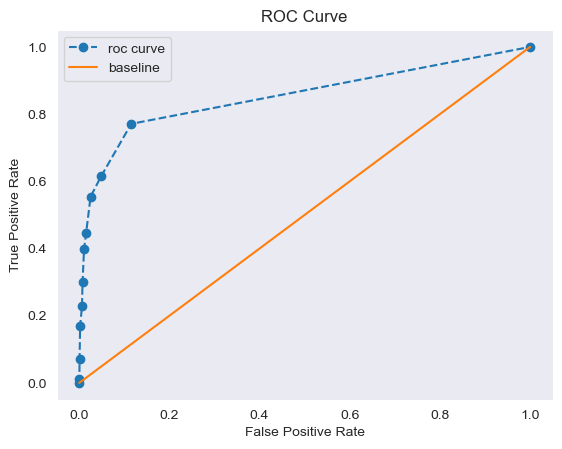

In [70]:
### GRADED
fpr, tpr, thresh_rocs = '', '', ''

### BEGIN SOLUTION
fpr, tpr, thresh_rocs = roc_curve(y_test, test_predictions[:, 1], pos_label='Yes')
### END SOLUTION

# Answer check
print('False Positive Rates: ', fpr[:5])
print('True Positive Rates: ', tpr[:5])
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

In [71]:
### BEGIN HIDDEN TESTS
fpr_, tpr_, thresh_rocs_ = roc_curve(y_test, test_predictions[:, 1], pos_label='Yes')
#
#
#
np.testing.assert_array_equal(fpr, fpr_)
np.testing.assert_array_equal(tpr, tpr_)
### END HIDDEN TESTS

[Back to top](#-Index)

### Problem 6

#### Area Under Curve as metric

**10 Points**

Finally, consider the proposed area under the curve scoring method described in the lectures.  Below, construct a grid search named `roc_grid` that uses the `knn_pipe` and searches over the number of neighbors from 1 to 31 by odd values, choosing the model that optimizes `roc_auc_score`.  Identify the optimal number of neighbors and assign to `best_k` below.  

In [72]:
### GRADED
roc_grid = ''
best_k = ''

### BEGIN SOLUTION
roc_grid = GridSearchCV(knn_pipe, param_grid={'knn__n_neighbors': range(1, 33, 2)}, scoring = 'roc_auc')
roc_grid.fit(X_train, y_train)
best_k = roc_grid.best_params_['knn__n_neighbors']
### END SOLUTION

# Answer check
best_k

29

In [73]:
### BEGIN HIDDEN TESTS
roc_grid_ = GridSearchCV(knn_pipe, param_grid={'knn__n_neighbors': range(1, 33, 2)}, scoring = 'roc_auc')
roc_grid_.fit(X_train, y_train)
best_k_ = roc_grid_.best_params_['knn__n_neighbors']
#
#
#
assert best_k == best_k_
### END HIDDEN TESTS

#### Visualizing with scikitlearn

Below, we use the `RocCurveDisplay` to display roc curves for three knn models.  You can either use predictions or estimators to create the visualization.  Below, we use the `from_estimator` method.

In [74]:
from sklearn.metrics import RocCurveDisplay

In [75]:
knn_1 = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier(n_neighbors = 1))])
knn_1.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['student'])])),
                ('knn', KNeighborsClassifier(n_neighbors=1))])

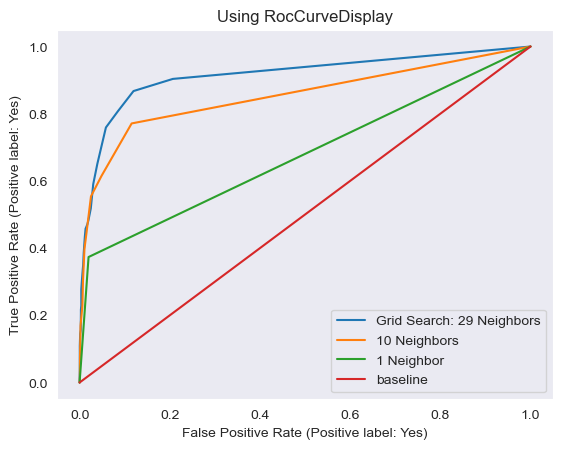

In [76]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(roc_grid, X_test, y_test, pos_label = 'Yes', ax = ax, label = 'Grid Search: 29 Neighbors')
RocCurveDisplay.from_estimator(knn_pipe, X_test, y_test, pos_label = 'Yes', ax = ax, label = '10 Neighbors')
RocCurveDisplay.from_estimator(knn_1, X_test, y_test, ax = ax, label = '1 Neighbor')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();